## ANÁLISE EXPLORATÓRIA DE DADOS

#### Imports

In [5]:
import pandas as pd
import datetime
import glob
from minio import Minio
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
client = Minio(
        "localhost:9000",
        access_key="minioadmin",
        secret_key="minioadmin",
        secure=False
    )

#### Baixando o dataset final no datalake

In [7]:
client.fget_object(
            "processing",
            "employees_dataset.parquet",
            "temp_.parquet",
)

In [8]:
df = pd.read_parquet("temp_.parquet")
print(df.shape)
df.head()

(15000, 9)


,department,salary,left,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident
0,sales,low,1.0,266.000000,2.0,38.0,53.0,3.0,0.0
1,sales,medium,1.0,252.000000,5.0,80.0,86.0,6.0,0.0
2,sales,medium,1.0,289.666667,7.0,11.0,88.0,4.0,0.0
3,sales,low,1.0,275.666667,5.0,72.0,87.0,5.0,0.0
4,sales,low,1.0,292.333333,2.0,37.0,52.0,3.0,0.0


#### Formatando a estrutura dos dados

##### Reordenar colunas

In [9]:
# Reordenanddo as colunas
df = df[['department', 'salary', 'mean_work_last_3_months',
       'number_projects', 'satisfaction_level', 'last_evaluation',
       'time_in_company', 'work_accident','left']]

In [10]:
df.head(1)

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266.0,2.0,38.0,53.0,3.0,0.0,1.0


In [11]:
df.isnull().sum()

department                 1
salary                     1
mean_work_last_3_months    0
number_projects            1
satisfaction_level         1
last_evaluation            1
time_in_company            1
work_accident              1
left                       1
dtype: int64

In [12]:
df.dropna(inplace=True)

##### Alterando os tipos de dados

In [13]:
df["number_projects"] = df["number_projects"].astype(int)
df["mean_work_last_3_months"] = df["mean_work_last_3_months"].astype(int)
df["time_in_company"] = df["time_in_company"].astype(int)
df["work_accident"] = df["work_accident"].astype(int)
df["left"] = df["left"].astype(int)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   department               14999 non-null  object 
 1   salary                   14999 non-null  object 
 2   mean_work_last_3_months  14999 non-null  int32  
 3   number_projects          14999 non-null  int32  
 4   satisfaction_level       14999 non-null  float64
 5   last_evaluation          14999 non-null  float64
 6   time_in_company          14999 non-null  int32  
 7   work_accident            14999 non-null  int32  
 8   left                     14999 non-null  int32  
dtypes: float64(2), int32(5), object(2)
memory usage: 878.8+ KB


##### Renomeando atributos

In [15]:
df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_projects': 'projectCount',
                        'mean_work_last_3_months': 'averageMonthlyHours',
                        'time_in_company': 'yearsAtCompany',
                        'work_accident': 'workAccident',
                        'left' : 'turnover'
                        })

In [16]:
df.head(1)

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
0,sales,low,266,2,38.0,53.0,3,0,1


#### AED - Análise exploratória dos dados

##### Resumo
- 14.998 observações de empregados e 9 atributos.
- A empresa tem uma rotatividade de 24%.
- A satisfação média dos empregados é de 61.
- A satisfação média dos empregados que deixaram a empresa é 49, variável que mais se diferencia entre os 2 grupos
- Correlação positiva moderada (34%) entre os atributos projectCount e Evaluation. Talvez empregados que estão envolvidos em mais projetos trabalhem mais, sabem resolver mais problemas diferentes e tëm melhor avaliação.
- Correlação negativa moderada (39%) entre os atributos satisfaction e turnover. Podemos  que empregados que mais deixam a empresa estão menos satisfeitos.
- Existe um pico de empregados com baixa satisfação, mas a maior concentração está em 60 a 80.
- A maioria dos empregados que saíram tinha salário **baixo** ou **médio**. Quase nenhum empregado com alto salário deixou a empresa.
- Os departamentos de vendas, técnico e suporte são top 3 departamentos com maior índice de turnover. O departamento management tem o menor volume de turnover.
- Alta taxa de turnover de empregados com 2 projetos (se sentem subuttilizados?) e 6-7 projetos (se sentem sobreccaregados). Parece haver uma faixa ótima de número de projetos por funcionário: entre 3 e 4.
 - Saída dos melhores e piores colaboradores em termos de avaliação. Talvez os piores sejam demitidos ou saem para procurar vagas mais alinhadas ao seu nível técnico. E os melhores podem estar recebendo propostas melhores ou almejando vagas de maior senioridade fora da empresa.
-  Para o grupo de pessoas que permaneceram na empresa, os empregados tiveram uma **pontuação de avaliação consistente**, apesar do aumento nas contagens de projetos.
Já para o grupo que sai, a nota de avaliação parece aumentar com o número de projetos.
- Três sub-grupos bem definidos dentro do grupo de funcionários que saem da empresa: 
- 1.Funcionários mal avaliados e insatisfeitos
- 2.Funcionários bem avaliados e insatisfeitos
- 3.Funcionários bem avaliados e bem satisfeitos

##### Estatísticas descritivas

In [17]:
df.describe()

,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,275.685579,3.803054,61.283352,71.610174,3.498233,0.144610,0.238083
std,10.054675,1.232592,24.863065,17.116911,1.460136,0.351719,0.425924
min,232.000000,2.000000,9.000000,36.000000,2.000000,0.000000,0.000000
25%,269.000000,3.000000,44.000000,56.000000,3.000000,0.000000,0.000000
50%,276.000000,4.000000,64.000000,72.000000,3.000000,0.000000,0.000000
75%,282.000000,5.000000,82.000000,87.000000,4.000000,0.000000,0.000000
max,321.000000,7.000000,100.000000,100.000000,10.000000,1.000000,1.000000


##### Turnover de funcionários

In [37]:
turnover_rate = df.turnover.value_counts() / len(df)
turnover_summary = df.groupby('turnover')
turnover_summary.mean()

,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident
turnover,,,,,,
0,275.704235,3.786664,66.680959,71.547340,3.380032,0.175009
1,275.625875,3.855503,44.009801,71.811257,3.876505,0.047326


Turnover em relação ao salário

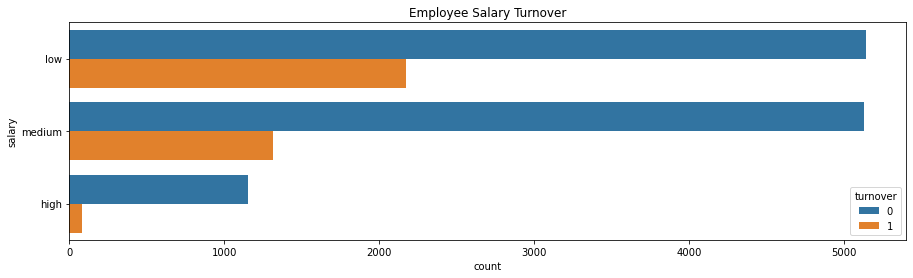

In [27]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="salary", hue='turnover', data=df).set_title('Employee Salary Turnover');

Turnover em relação ao número de projetos

[]

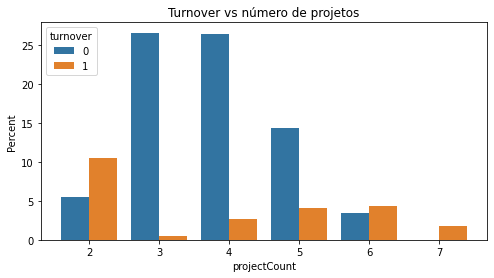

In [30]:
fig = plt.figure(figsize=(8,4),)
ax = sns.barplot(x="projectCount", y="projectCount", hue="turnover", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
plt.title('Turnover vs número de projetos')
plt.plot()

Turnover em relação ao departamento de trabalho

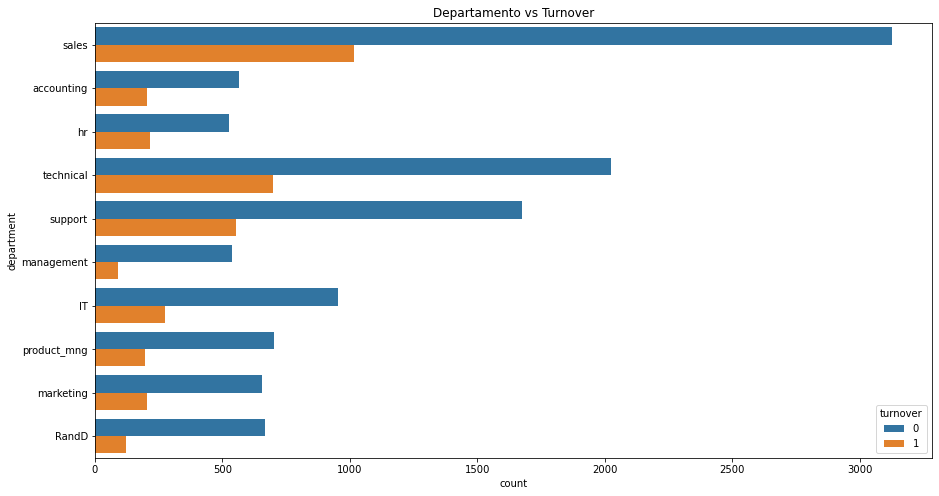

In [29]:
f, ax = plt.subplots(figsize=(15, 8))
sns.countplot(y="department", hue='turnover', data=df).set_title('Departamento vs Turnover');

Turnover em relação à avaliação

[]

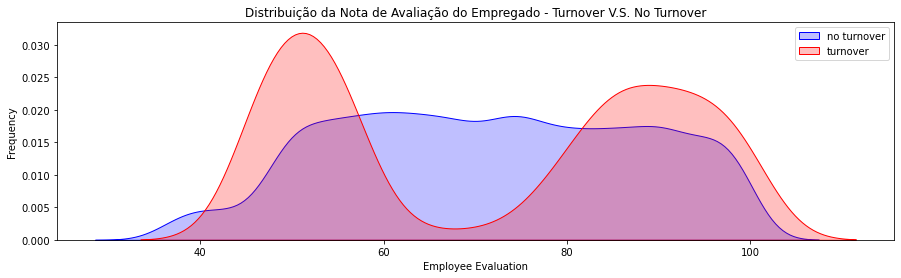

In [32]:
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'evaluation'] , color='b',shade=True,label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'evaluation'] , color='r',shade=True, label='turnover')
ax.set(xlabel='Employee Evaluation', ylabel='Frequency')
plt.title('Distribuição da Nota de Avaliação do Empregado - Turnover V.S. No Turnover')
plt.legend()
plt.plot()

 - Distribuição bimodal para o conjunto que deixou a empresa: saída dos melhores e piores colaboradores em termos de avaliação

Turnover em relação ao nível de satisfação e número de projetos

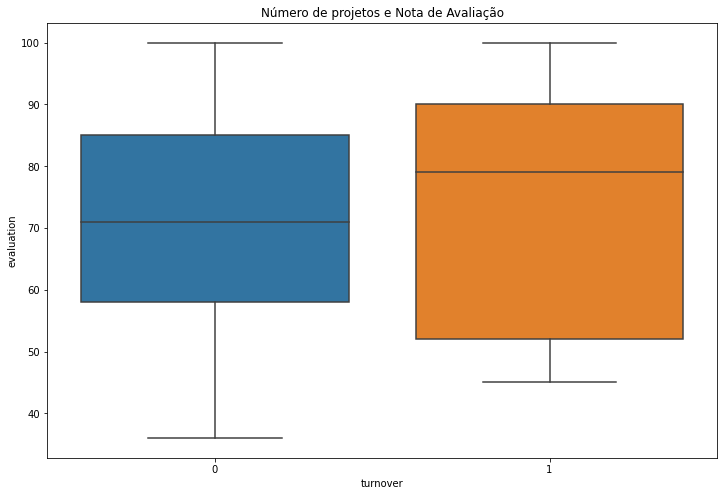

In [34]:
# Apenas satisfação em função do turnover
fig = plt.figure(figsize=(12, 8))
import seaborn as sns
sns.boxplot(x="turnover", y="evaluation", data=df)
plt.title("Número de projetos e Nota de Avaliação")
plt.show()

Todos os funcionários muito mal avaliados (< 45) saíram da empresa. Há funcionários bem avaliados que permanecem e outros que saem. Em média, funcionários que saem e que permanecem têm a mesma nota de avaliação.

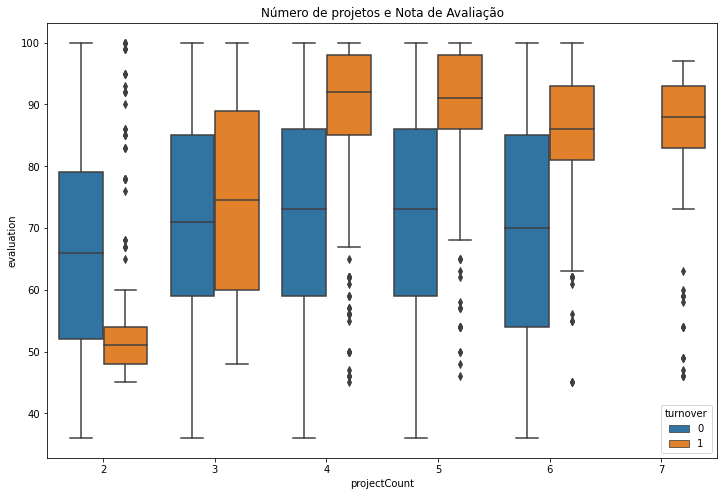

In [35]:
# Desmembrando para número de projetos
fig = plt.figure(figsize=(12, 8))
import seaborn as sns
sns.boxplot(x="projectCount", y="evaluation", hue="turnover", data=df)
plt.title("Número de projetos e Nota de Avaliação")
plt.show()

Para o grupo de pessoas que permaneceram na empresa, os empregados tiveram uma **pontuação de avaliação consistente**, apesar do aumento nas contagens de projetos.
Já para o grupo que sai, a nota de avaliação parece aumentar com o número de projetos.


Mais empregados com avaliação alta tendem a deixar a empresa a partir de 3 projeto.

##### Correlação entre vars

<AxesSubplot:>

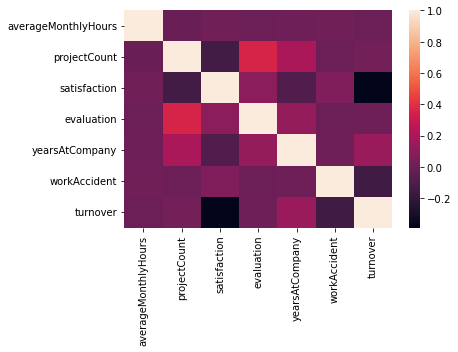

In [22]:
corr = df.corr()
corr = (corr)
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values)

In [24]:
corr

,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
averageMonthlyHours,1.000000,-0.009790,0.007669,-0.007087,0.004822,0.011991,-0.003319
projectCount,-0.009790,1.000000,-0.142970,0.349333,0.196786,-0.004741,0.023787
satisfaction,0.007669,-0.142970,1.000000,0.105021,-0.100866,0.058697,-0.388375
evaluation,-0.007087,0.349333,0.105021,1.000000,0.131591,-0.007104,0.006567
yearsAtCompany,0.004822,0.196786,-0.100866,0.131591,1.000000,0.002120,0.144822
workAccident,0.011991,-0.004741,0.058697,-0.007104,0.002120,1.000000,-0.154622
turnover,-0.003319,0.023787,-0.388375,0.006567,0.144822,-0.154622,1.000000


##### Distribuição das principais vars

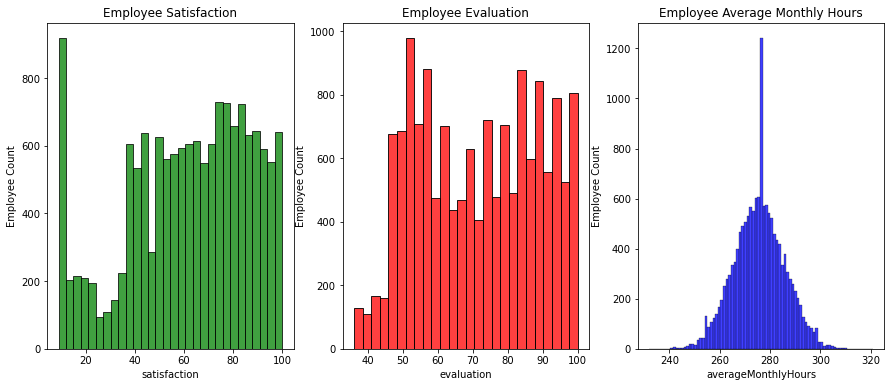

In [26]:
f, axes = plt.subplots(ncols=3, figsize=(15, 6))

sns.histplot(df.satisfaction, kde=False, color="g", ax=axes[0]).set_title('Employee Satisfaction')
axes[0].set_ylabel('Employee Count')

sns.histplot(df.evaluation, kde=False, color="r", ax=axes[1]).set_title('Employee Evaluation')
axes[1].set_ylabel('Employee Count')

sns.histplot(df.averageMonthlyHours, kde=False, color="b", ax=axes[2]).set_title('Employee Average Monthly Hours')
axes[2].set_ylabel('Employee Count')
plt.show()

Pico de empregados com baixa satisfação.

Grupos de satisfação x avaliação: funcionários mais satisfeitos desempenham melhor na avaliação?

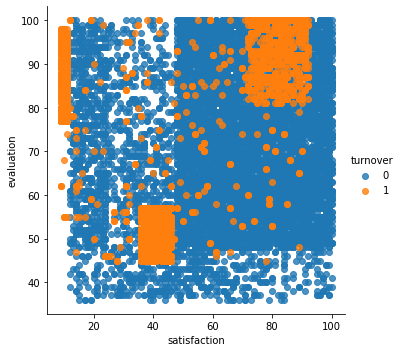

In [39]:
sns.lmplot(x = 'satisfaction', 
           y = 'evaluation', 
           data = df,
           fit_reg = False,
           hue='turnover')

Parece haver 3 sub-grupo bem definidos dentro do grupo de funcionários que saem da empresa: 
- 1.Funcionários mal avaliados e insatisfeitos
- 2.Funcionários bem avaliados e insatisfeitos
- 3.Funcionários bem avaliados e bem satisfeitos (e que ainda sim saem. Propostas melhores?)

Vamos fazer uma clusterização para deixar a análise mais estruturada e podermos prever futuramente a qual dos 3 grupos um funcionário pertence, de acordo com os valores dos seus atributos.

#### Clusterização dos grupos de avaliação x satisfação


- **Cluster 0 (Verde):** Empregados bem avaliados e satisfeitos.
- **Cluster 1 (Vermelho):** Empregados mal avaliados e insatisfeitos. 
- **Cluster 2 (Azul):** Empregados bem avaliados e insatisfeitos.

In [41]:

df_turnover = df[df.turnover==1][["satisfaction","evaluation"]]

In [42]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(df_turnover)
kmeans_colors = ['green' if c == 0 else 'red' if c == 1 else 'blue' for c in kmeans.labels_]

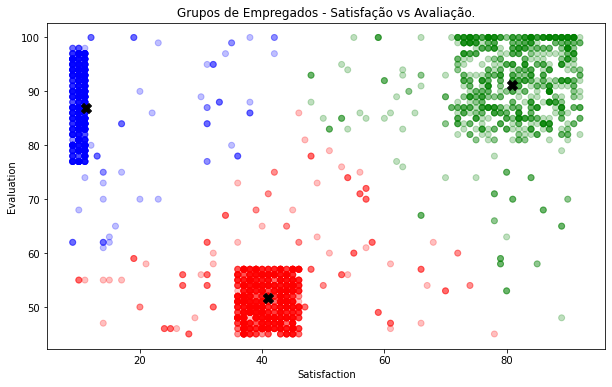

In [43]:
fig = plt.figure(figsize=(10, 6))
plt.scatter( x="satisfaction"
            ,y="evaluation"
            ,data=df_turnover,
            alpha=0.25,color = kmeans_colors)

plt.xlabel("Satisfaction")
plt.ylabel("Evaluation")

plt.scatter( x=kmeans.cluster_centers_[:,0]
            ,y=kmeans.cluster_centers_[:,1]
            ,color="black"
            ,marker="X",s=100)

plt.title("Grupos de Empregados - Satisfação vs Avaliação.")
plt.show()

Guardando o algoritmo treinado no datalake:

In [45]:
import joblib
joblib.dump(kmeans, "cluster.joblib")

client.fput_object(
    "curated",
    "cluster.joblib",
    "cluster.joblib"
)